In [50]:
### Imports ###
import gensim
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import pylab as pl
import numpy as np

In [39]:
import os
import pymongo as py

# Database info
client = py.MongoClient('mongodb://cosmo-feynman:4rDaE4LwLhwtwKCRIID7BV42Dpz9JOcj3H8kTDUqDmDbkmJiW4HqcGmktibeGWdAkFE5ZE8bQPvR1EncGLSiGA==@cosmo-feynman.documents.azure.com:10255/?ssl=true&replicaSet=globaldb')
db = client.ch

# Gather files of interest
data = db.docs.find(
    {
        'filetype': 'pdf',
        'doctype': 'annual-returns',
        'extracted_hand': {'$exists': True}
    })
print('Finished...')

Finished...


In [40]:
### Convert data to tagged format ###
tagged_data = []
filenames = []

for item in data:
    tagged_data.append(TaggedDocument(words=item['extracted_hand'], tags=[item['filename']]))
    filenames.append(item['filename'])
print('Finished...')

Finished...


In [23]:
### Build Model ###
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.025,
                min_count=1,
                dm=1)
  
model.build_vocab(tagged_data)

print('Running...')

for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Doc2Vec Model Saved")
model.save_word2vec_format('w2v.model')
print("Word2Vec Model Saved")

Running...
Doc2Vec Model Saved
Word2Vec Model Saved


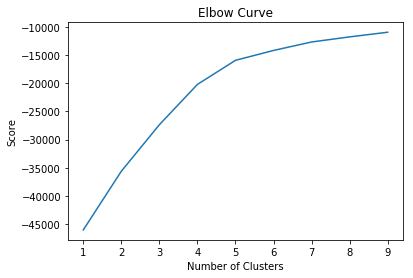

In [27]:
### Identify no. of clusters using elbow curve ###

# Load doc2vec model if not already loaded
d2v_model= Doc2Vec.load("d2v.model")

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i, init='k-means++', max_iter=100) for i in Nc]
# kmeans
Y = d2v_model.docvecs.doctag_syn0
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]
# score
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

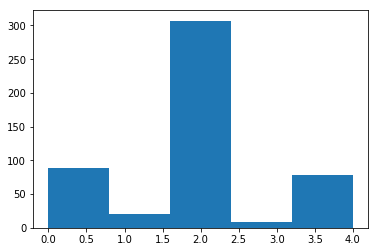

In [33]:
### Use K-Means to cluster data ###

# Load doc2vec model
d2v_model= Doc2Vec.load("d2v.model")

k = 5
kmeans_model = KMeans(n_clusters=k, init='k-means++', max_iter=100)  

# Cluster points
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()    

# Create cluster centres
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)

plt.hist(kmeans_model.labels_, bins=k)
plt.show()

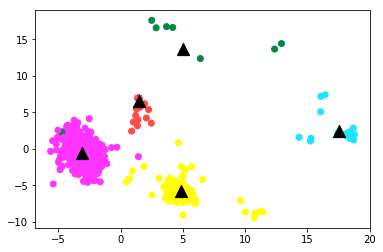

In [34]:
### Plot in 2d ###
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

plt.figure
c_map = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
        "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
        "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58",
        
        "#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D",
        "#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176",
        "#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5",
        "#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4",
        "#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01",
        "#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966",
        "#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0",
        "#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C",

        "#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868",
        "#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183",
        "#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433",
        "#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F",
        "#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E",
        "#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F",
        "#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00",
        "#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66",
        
        "#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25",
        "#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B"]

colour = [c_map[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=colour)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [47]:
### Save model ###
from sklearn.externals import joblib

# Check cluster centres
# print(kmeans_model.cluster_centers_)

# save the model to disk
filename = 'kmeans_model.sav'
joblib.dump(kmeans_model, filename)
print('Model saved...')

Model saved...


In [52]:
### Load model ###
kmeans_model = joblib.load(filename)
print('Model loaded...')
# print(kmeans_model.cluster_centers_)

Model loaded...


In [74]:
### Get results ###
import collections, pprint

model= Doc2Vec.load("d2v.model")
kmeans_model = joblib.load(filename)

results = {}

for filen in filenames:
    vec = model.docvecs[filen]
    sim_doc = model.docvecs.most_similar([vec])
    clust = kmeans_model.predict([vec])
    results[filen] = {}
    results[filen]['vectors'] = vec
    results[filen]['similar_docs'] = sim_doc
    results[filen]['cluster'] = clust

print('Random result:')
pp = pprint.PrettyPrinter(indent=1)
pp.pprint(next (iter (results.values())))

Random result:
{'cluster': array([3], dtype=int32),
 'similar_docs': [('02374461_annual-returns_2017-05-01.pdf',
                   0.9999999403953552),
                  ('08703677_annual-returns_2016-12-06.pdf',
                   0.9741925597190857),
                  ('04785954_annual-returns_2017-06-14.pdf',
                   0.9691190719604492),
                  ('08498015_annual-returns_2017-05-01.pdf', 0.967235267162323),
                  ('05399829_annual-returns_2017-03-20.pdf', 0.966727614402771),
                  ('06997138_annual-returns_2017-02-20.pdf',
                   0.9651126861572266),
                  ('07425534_annual-returns_2016-11-07.pdf',
                   0.9646397233009338),
                  ('10186380_annual-returns_2017-06-07.pdf',
                   0.9610203504562378),
                  ('08534118_annual-returns_2017-06-05.pdf',
                   0.9607982635498047),
                  ('05583266_annual-returns_2016-10-11.pdf',
                  

In [59]:
### Predict vec and cluster ###
# Load models if not already done
d2v_model= Doc2Vec.load("d2v.model")
kmeans_model = joblib.load(filename)

#to find the vector of a document which is not in training data
test_data = word_tokenize("Human Immunodeficiency Virus 1 uses for entry into host cells a receptor and one of two co-receptors.".lower())
vec = d2v_model.infer_vector(test_data)
sim_doc = d2v_model.docvecs.most_similar([vec])
clust = kmeans_model.predict([vec])

print('Testing unseen data \n')
print('Infered doc2vec vector:')
print(vec, '\n')
print('Similar documents:')
print(sim_doc, '\n')
print('Predicted cluster:')
print(clust)

Testing unseen data 

Infered doc2vec vector:
[-0.04467064 -0.0497687  -0.20206808  0.28245252  0.03920534 -0.230239
 -0.31310135 -0.07032774 -0.45669794 -0.5662798   0.12720425 -0.23232889
 -0.26006764 -0.27035436 -0.4027501  -0.16504706 -0.25329044  0.09978803
  0.5507636   0.13746937] 

Similar documents:
[('00984275_annual-returns_2015-05-29.pdf', 0.5602951049804688), ('02725280_annual-returns_2018-01-05.pdf', 0.5545044541358948), ('08807751_annual-returns_2016-12-12.pdf', 0.5428720712661743), ('04871166_annual-returns_2015-10-01.pdf', 0.5301312208175659), ('00984275_annual-returns_2013-03-01.pdf', 0.5159821510314941), ('08799092_annual-returns_2017-01-03.pdf', 0.47090572118759155), ('07245047_annual-returns_2017-05-19.pdf', 0.4611961841583252), ('08151156_annual-returns_2016-08-03.pdf', 0.45253175497055054), ('00984275_annual-returns_2014-03-01.pdf', 0.44757288694381714), ('SC269235_annual-returns_2016-07-26.pdf', 0.4450336694717407)] 

Predicted cluster:
[0]
